In [1]:
import os
os.environ['CUPY_ACCELERATORS'] = 'cutensor'
import numpy as np
import cupy as cp
from cupyx.scipy import fft as cupyx_fft
from scipy import misc, fft as scipy_fft
import zarr
from matplotlib import pyplot, colors, cm
from PIL import Image
from tqdm.notebook import tqdm
from IPython.display import display

In [2]:
cp.cuda.set_pinned_memory_allocator(None)
mempool = cp.get_default_memory_pool()

In [3]:
# Plot functions

colors.get_named_colors_mapping().update({
    'lfd:signal': "#4e79a7",
    'lfd:pupil': "#59a14f",
    'lfd:retina': "#e15759",
    'lfd:filter': "#f28e2b",
})

my_colors = ["#4e79a7", "#e15759", "#59a14f", "#f28e2b"]



# Basic array functions

def sampling_lattice(res, pitch=1.0):
    """Return an array of shape (res,) containing the coordinates of a sampling lattice with a given pitch in "standard" order (with zero at the start)."""
    return scipy_fft.fftfreq(res).astype(np.float32) * (res * pitch)

def display_image(values, color_map=None, absolute=True, normalize=True, shift=False, flip=False):
    """Display an array as an image using a color map. The image can be normalized, shifted and/or flipped."""
    values = np.abs(values) if absolute else values
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    values = scipy_fft.fftshift(values) if shift else values
    values = np.flip(values) if flip else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))



# Spatial and spectral transformations between the display and the eye spaces

def x_ab_to_r(x_a, x_b, z_r, z_a, z_b, z_f):
    """Return the position on the retina from the positions on the display layers."""
    return (1 - z_b/z_f) * z_r/(z_a - z_b) * x_a + (1 - z_a/z_f) * z_r/(z_b - z_a) * x_b

def x_ab_to_p(x_a, x_b, z_a, z_b):
    """Return the position on the pupil from the positions on the display layers."""
    return z_b/(z_b - z_a) * x_a + z_a/(z_a - z_b) * x_b

def x_rp_to_a(x_r, x_p, z_r, z_a, z_f):
    """Return the position on the display layer A from the positions on the retina and pupil."""
    return (z_a/z_r) * x_r + (1 - z_a/z_f) * x_p

def x_rp_to_b(x_r, x_p, z_r, z_b, z_f):
    """Return the position on the display layer B from the positions on the retina and pupil."""
    return (z_b/z_r) * x_r + (1 - z_b/z_f) * x_p

def xi_ab_to_r(xi_a, xi_b, z_r, z_a, z_b):
    """Return the frequency on the retina from the frequencies on the display layers."""
    return (z_a/z_r) * xi_a + (z_b/z_r) * xi_b

def xi_ab_to_p(xi_a, xi_b, z_a, z_b, z_f):
    """Return the frequency on the pupil from the frequencies on the display layers."""
    return (1 - z_a/z_f) * xi_a + (1 - z_b/z_f) * xi_b

def xi_rp_to_a(xi_r, xi_p, z_r, z_a, z_b, z_f):
    """Return the frequency on the display layer A from the frequencies on the retina and pupil."""
    return (1 - z_b/z_f) * z_r/(z_a - z_b) * xi_r + z_b/(z_b - z_a) * xi_p

def xi_rp_to_b(xi_r, xi_p, z_r, z_a, z_b, z_f):
    """Return the frequency on the display layer B from the frequencies on the retina and pupil."""
    return (1 - z_a/z_f) * z_r/(z_b - z_a) * xi_r + z_a/(z_a - z_b) * xi_p

In [4]:
z_r = -17.0
z_a = 10.0
z_b = 30.0

size_r = 5.5
size_p = 5.0
size_a = size_r * z_a / abs(z_r) + size_p
size_b = size_r * z_b / abs(z_r) + size_p

res_r = 375
res_a = 5
res_b = 5

pitch_r = size_r / res_r
pitch_a = size_a / res_a
pitch_b = size_b / res_b

w_r = size_r
w_p = size_p
w_a = pitch_a
w_b = pitch_b

z_f = 100.0

Convolution:
$$ \begin{align*}
    (f * g)(x) = \int_{-\infty}^{\infty} f(t) \, g(x - t) \, \mathrm{d}t && (1.1)\\
\end{align*} $$

Therefore:
$$ \begin{align*}
    (f * g)(0) = \int_{-\infty}^{\infty} f(t) \, g^{\vee}\!(t) \, \mathrm{d}t && (1.2)\\
\end{align*} $$

Retina image:
$$ \begin{align*}
    E(x_r) = \int_{-\infty}^{\infty} L(x_r, x_p) \, P(x_p) \, \mathrm{d}x_p = (L * P^{\vee})(x_r, 0) = (L * P)(x_r, 0) && (1.3)\\
\end{align*} $$

Therefore we have:
$$ \begin{align*}
    f &= (L * P)(x_r, 0) && (1.4)\\
    \tilde{f} &= (\tilde{L} * P)(x_r, 0) = (\boldsymbol{c} * D * P)(x_r, 0) = (\boldsymbol{c} * \varphi)(x_r, 0) && (1.5)\\
    \varphi &= D * P && (1.6)\\
\end{align*} $$

Orthogonal projection:
$$ \begin{align*}
    (f - \tilde{f}) \bot V_{\varphi} \iff \langle f - \tilde{f}, \varphi(\cdot - k) \rangle = 0 && \forall \, k \in \mathbb{Z} \iff \pmb{[} (f - \tilde{f}) * \varphi^{\vee} \pmb{]} = 0 && (1.7)\\
\end{align*} $$

From there:
$$ \begin{align*}
    \pmb{[} f * \varphi^{\vee} \pmb{]} = \pmb{[} \tilde{f} * \varphi^{\vee} \pmb{]} \implies
    \pmb{[} (L * P)(x_r, 0) * \varphi^{\vee} \pmb{]} = \pmb{[} (\boldsymbol{c} * \varphi)(x_r, 0) * \varphi^{\vee} \pmb{]} \implies
    \boldsymbol{b} = A \boldsymbol{c} && (1.8)\\
\end{align*} $$

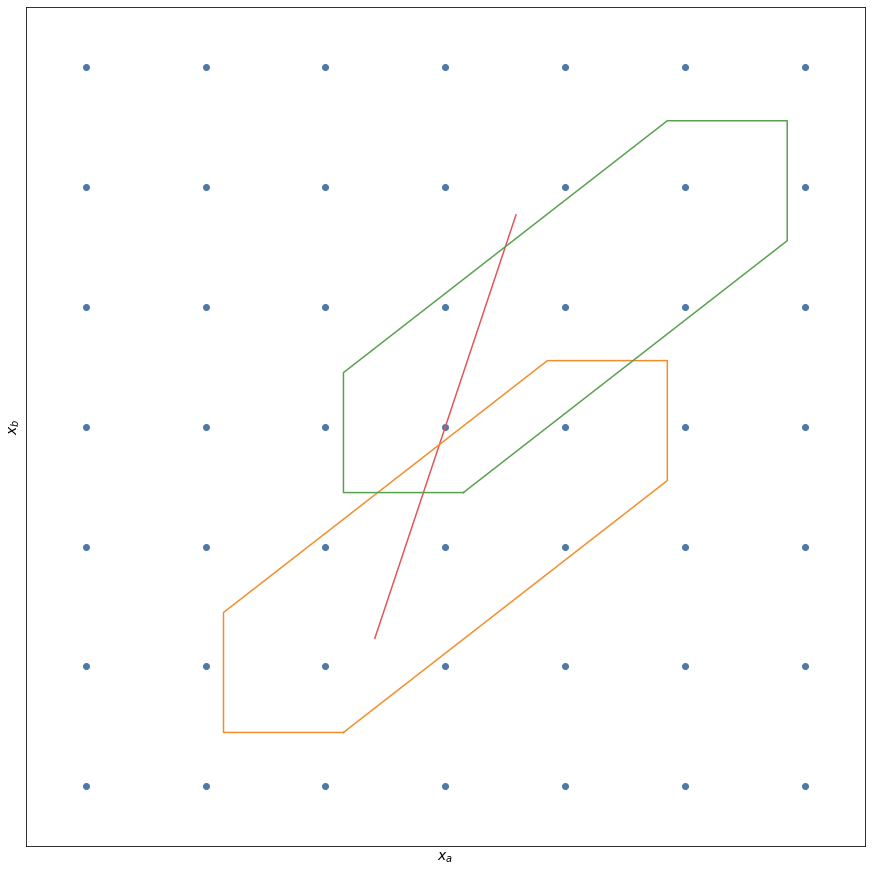

In [5]:
n = 7
l_r = [x_rp_to_a(1, 0, z_r, z_a, z_f), x_rp_to_b(1, 0, z_r, z_b, z_f)]
l_p = [x_rp_to_a(0, 1.5, z_r, z_a, z_f), x_rp_to_b(0, 1.5, z_r, z_b, z_f)]
phi = np.array([[0.5-l_p[0], -0.5-l_p[0], -0.5-l_p[0], -0.5+l_p[0], 0.5+l_p[0], 0.5+l_p[0], 0.5-l_p[0]], [-0.5-l_p[1], -0.5-l_p[1], 0.5-l_p[1], 0.5+l_p[1], 0.5+l_p[1], -0.5+l_p[1], -0.5-l_p[1]]])

c = sampling_lattice(n, 1)

fig, ax = pyplot.subplots(constrained_layout=True, figsize=(12, 12))

ax.set_xlabel(r'$x_a$', fontsize=14)
ax.set_ylabel(r'$x_b$', fontsize=14)
ax.set_aspect('equal')
ax.set_xticks([])
ax.set_yticks([])
ax.set_xlim(-n/2, n/2)
ax.set_ylim(-n/2, n/2)

ax.plot(l_r[0] * np.array([-1,1]), l_r[1] * np.array([-1,1]), color='lfd:retina')
ax.scatter(np.repeat(c, n), np.tile(c, n), color='lfd:signal')
ax.plot(phi[0], phi[1]-1, color='lfd:filter')
ax.plot(phi[0]+1, phi[1]+1, color='lfd:pupil')

pass

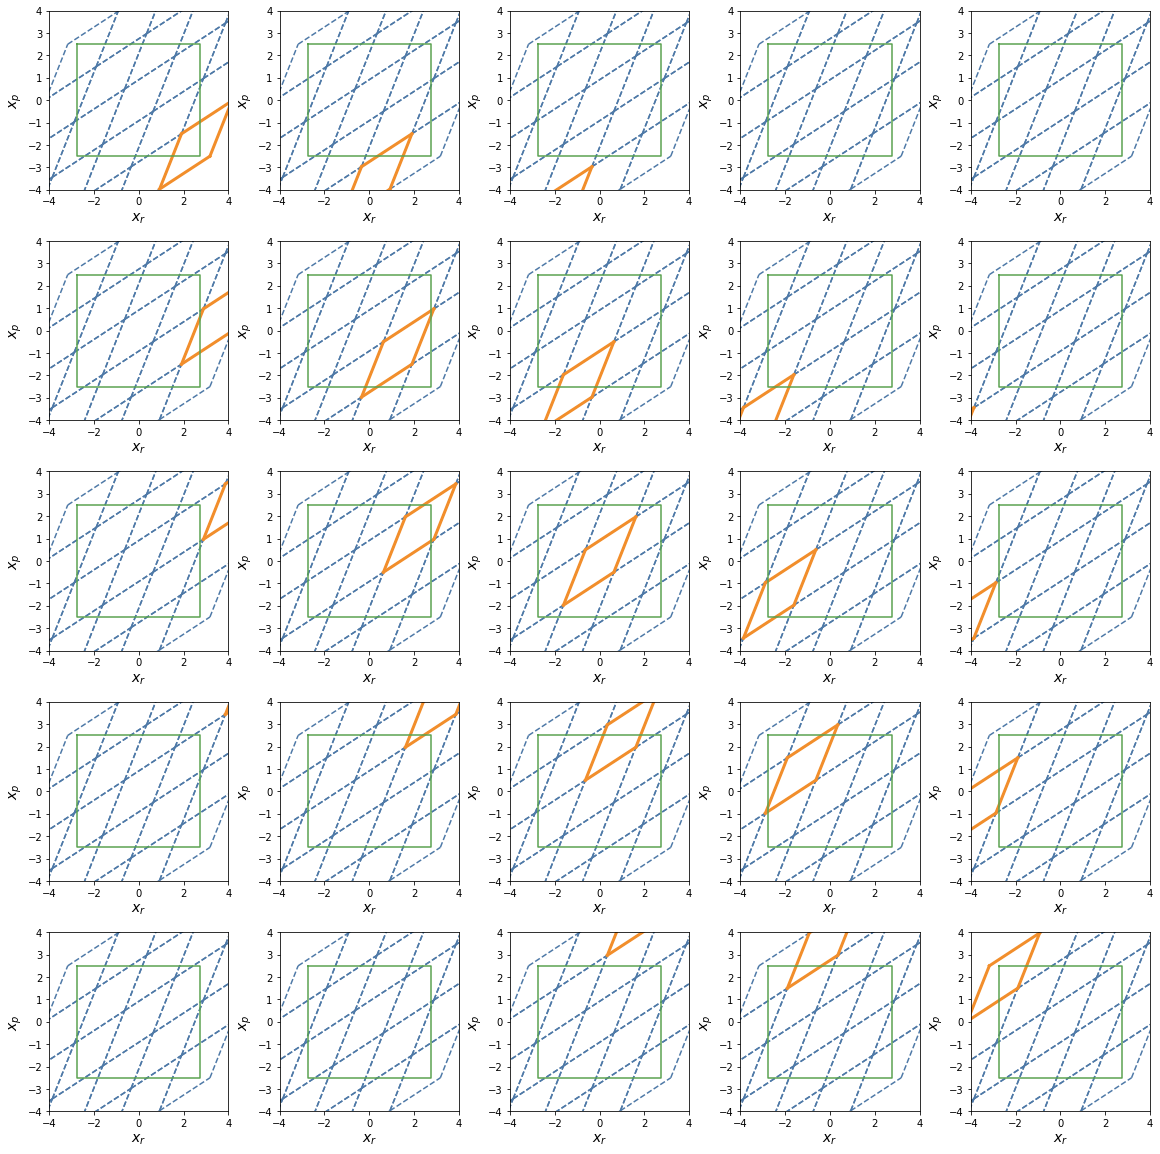

In [6]:
x_a_at_samples = scipy_fft.fftshift(sampling_lattice(res_a, pitch_a))[:, np.newaxis]
x_b_at_samples = scipy_fft.fftshift(sampling_lattice(res_b, pitch_b))[np.newaxis, :]

x_r_at_samples = x_ab_to_r(x_a_at_samples, x_b_at_samples, z_r, z_a, z_b, z_f)
x_p_at_samples = x_ab_to_p(x_a_at_samples, x_b_at_samples, z_a, z_b)

slope_a = np.reciprocal((1/z_f - 1/z_a) * z_r)
slope_b = np.reciprocal((1/z_f - 1/z_b) * z_r)

height_a = np.abs(np.reciprocal(1 - z_a/z_f) * w_a/2)
height_b = np.abs(np.reciprocal(1 - z_b/z_f) * w_b/2)

interval_top_a = (np.array([-1, 1]) * height_b * np.sign(slope_a - slope_b) - height_a) / (slope_a - slope_b)
interval_top_b = (np.array([-1, 1]) * height_a * np.sign(slope_b - slope_a) - height_b) / (slope_b - slope_a)
interval_bottom_a = (np.array([-1, 1]) * height_b * np.sign(slope_a - slope_b) + height_a) / (slope_a - slope_b)
interval_bottom_b = (np.array([-1, 1]) * height_a * np.sign(slope_b - slope_a) + height_b) / (slope_b - slope_a)

fig, axs = pyplot.subplots(res_a, res_b, constrained_layout=True, figsize=(16, 16))

for index in np.ndindex(res_a, res_b):
    axs[index].set_xlabel(r'$x_r$', fontsize=14)
    axs[index].set_ylabel(r'$x_p$', fontsize=14)
    axs[index].set_aspect('equal')
    axs[index].set_xlim(-4, 4)
    axs[index].set_ylim(-4, 4)

    for index_ in np.ndindex(res_a, res_b):
        axs[index].plot(interval_top_a + x_r_at_samples[index_], slope_a * interval_top_a + height_a + x_p_at_samples[index_], linestyle='--', color=my_colors[0])
        axs[index].plot(interval_top_b + x_r_at_samples[index_], slope_b * interval_top_b + height_b + x_p_at_samples[index_], linestyle='--', color=my_colors[0])
        axs[index].plot(interval_bottom_a + x_r_at_samples[index_], slope_a * interval_bottom_a - height_a + x_p_at_samples[index_], linestyle='--', color=my_colors[0])
        axs[index].plot(interval_bottom_b + x_r_at_samples[index_], slope_b * interval_bottom_b - height_b + x_p_at_samples[index_], linestyle='--', color=my_colors[0])
    
    axs[index].plot(interval_top_a + x_r_at_samples[index], slope_a * interval_top_a + height_a + x_p_at_samples[index], linewidth=3, color=my_colors[3])
    axs[index].plot(interval_top_b + x_r_at_samples[index], slope_b * interval_top_b + height_b + x_p_at_samples[index], linewidth=3, color=my_colors[3])
    axs[index].plot(interval_bottom_a + x_r_at_samples[index], slope_a * interval_bottom_a - height_a + x_p_at_samples[index], linewidth=3, color=my_colors[3])
    axs[index].plot(interval_bottom_b + x_r_at_samples[index], slope_b * interval_bottom_b - height_b + x_p_at_samples[index], linewidth=3, color=my_colors[3])

    axs[index].plot(np.array([-0.5, -0.5, 0.5, 0.5, -0.5]) * w_r, np.array([0.5, -0.5, -0.5, 0.5, 0.5]) * w_p, color=my_colors[2])

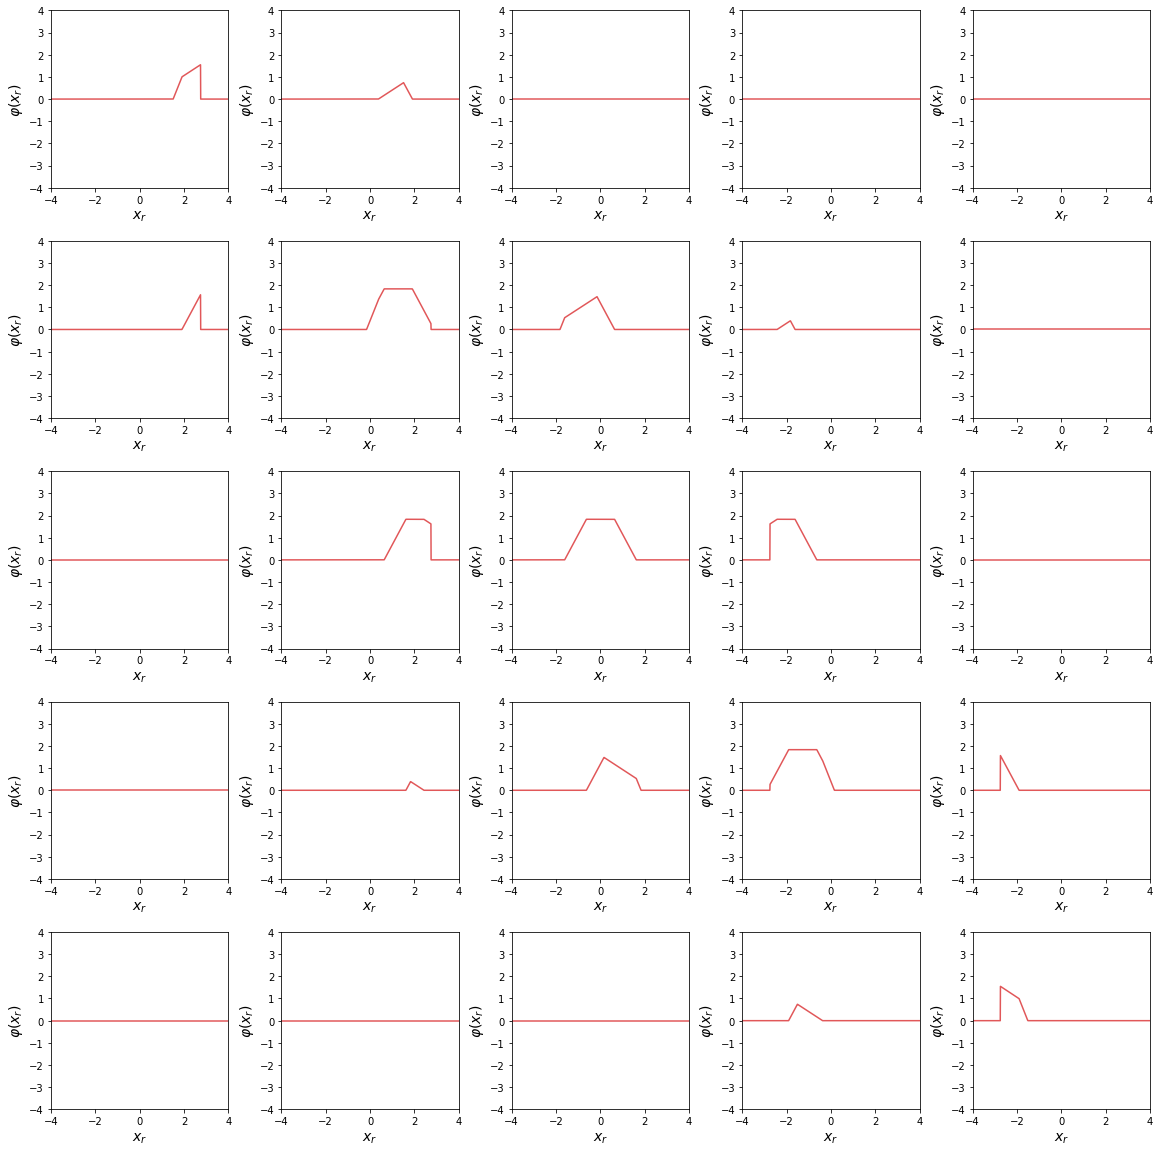

In [7]:
# shape = [l/r, t/b, a/b, 3, res_a, res_b]

x_r = np.linspace(-4.0, 4.0, num=1000)

intervals = np.transpose([[interval_top_a, interval_bottom_a], [interval_top_b, interval_bottom_b]])[:, :, :, np.newaxis, np.newaxis, np.newaxis]
slopes = np.transpose([[slope_a, slope_a], [slope_b, slope_b]])[:, :, np.newaxis, np.newaxis, np.newaxis]
heights = np.transpose([[height_a, -height_a], [height_b, -height_b]])[:, :, np.newaxis, np.newaxis, np.newaxis]

intervals = intervals + x_r_at_samples
heights = heights + x_p_at_samples - slopes * x_r_at_samples

intervals = np.clip(intervals, -w_r/2, w_r/2)

left_intersection = (-np.sign(slopes) * w_p/2 - heights) / slopes
right_intersection = (np.sign(slopes) * w_p/2 - heights) / slopes

intersected_intervals = np.stack([np.concatenate(np.broadcast_arrays(-np.inf, left_intersection, right_intersection), axis=2), np.concatenate(np.broadcast_arrays(left_intersection, right_intersection, np.inf), axis=2)])
intersected_intervals = np.clip(intersected_intervals, intervals[0], intervals[1])

intersected_slopes = np.concatenate(np.broadcast_arrays(0.0, slopes, 0.0), axis=2)
intersected_heights = np.concatenate(np.broadcast_arrays(-np.sign(slopes) * w_p/2, heights, np.sign(slopes) * w_p/2), axis=2)

intersected_slopes[1] *= -1
intersected_heights[1] *= -1

intersected_slopes = intersected_slopes.reshape(12, 1, 1)
intersected_heights = intersected_heights.reshape(12, res_a, res_b)
intersected_intervals = intersected_intervals.reshape(2, 12, res_a, res_b)

values = (intersected_slopes[..., np.newaxis] * x_r + intersected_heights[..., np.newaxis]) * (x_r > intersected_intervals[0, ..., np.newaxis]) * (x_r < intersected_intervals[1, ..., np.newaxis])
phi = np.sum(values, axis=0)

fig, axs = pyplot.subplots(res_a, res_b, constrained_layout=True, figsize=(16, 16))

for index in np.ndindex(res_a, res_b):
    axs[index].set_xlabel(r'$x_r$', fontsize=14)
    axs[index].set_ylabel(r'$\varphi(x_r)$', fontsize=14)
    axs[index].set_aspect('equal')
    axs[index].set_xlim(-4.0, 4.0)
    axs[index].set_ylim(-4.0, 4.0)

    axs[index].plot(x_r, phi[index], color=my_colors[1])

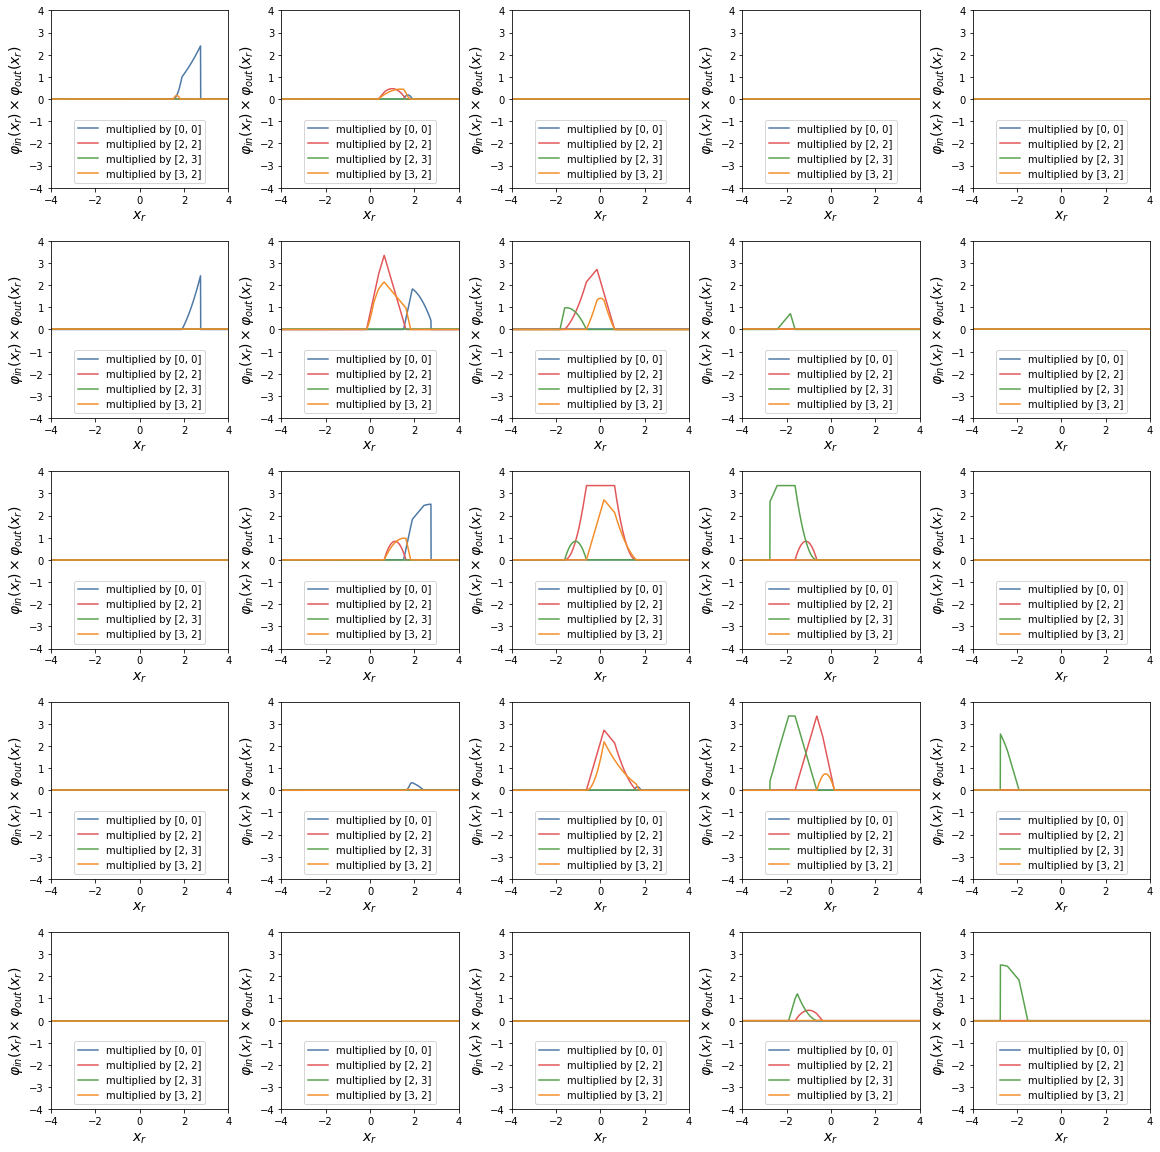

In [8]:
# shape = [l/r, 12, in_a, in_b, 12, out_a, out_b]

in_intervals = intersected_intervals[:, ..., np.newaxis, np.newaxis, np.newaxis]
out_intervals = intersected_intervals[:, np.newaxis, np.newaxis, np.newaxis, ...]

in_slopes = intersected_slopes[..., np.newaxis, np.newaxis, np.newaxis]
out_slopes = intersected_slopes[np.newaxis, np.newaxis, np.newaxis, ...]

in_heights = intersected_heights[..., np.newaxis, np.newaxis, np.newaxis]
out_heights = intersected_heights[np.newaxis, np.newaxis, np.newaxis, ...]

combined_intervals = np.clip(in_intervals, out_intervals[0], out_intervals[1])

order_2 = in_slopes * out_slopes
order_1 = in_slopes * out_heights + in_heights * out_slopes
order_0 = in_heights * out_heights

values = (order_2[..., np.newaxis] * np.square(x_r) + order_1[..., np.newaxis] * x_r + order_0[..., np.newaxis]) * (x_r > combined_intervals[0, ..., np.newaxis]) * (x_r < combined_intervals[1, ..., np.newaxis])
phiphi = np.sum(values, axis=(0, 3))

fig, axs = pyplot.subplots(res_a, res_b, constrained_layout=True, figsize=(16, 16))

for index in np.ndindex(res_a, res_b):
    axs[index].set_xlabel(r'$x_r$', fontsize=14)
    axs[index].set_ylabel(r'$\varphi_{in}(x_r) \times \varphi_{out}(x_r)$', fontsize=14)
    axs[index].set_aspect('equal')
    axs[index].set_xlim(-4.0, 4.0)
    axs[index].set_ylim(-4.0, 4.0)

    axs[index].plot(x_r, phiphi[0, 0][index], color=my_colors[0], label='multiplied by [0, 0]')
    axs[index].plot(x_r, phiphi[2, 2][index], color=my_colors[1], label='multiplied by [2, 2]')
    axs[index].plot(x_r, phiphi[2, 3][index], color=my_colors[2], label='multiplied by [2, 3]')
    axs[index].plot(x_r, phiphi[3, 2][index], color=my_colors[3], label='multiplied by [3, 2]')

    axs[index].legend(loc='lower center')

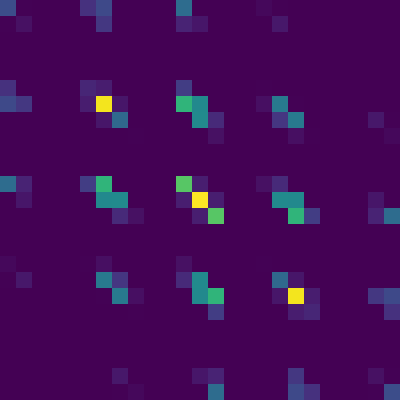

LinAlgError: Singular matrix

In [9]:
antiderivative = order_2 * np.power(combined_intervals, 3)/3 + order_1 * np.power(combined_intervals, 2)/2 + order_0 * combined_intervals

matrix_25by25 = np.sum(antiderivative[1] - antiderivative[0], axis=(0, 3)).reshape(25, 25)

display_image(np.kron(np.flipud(matrix_25by25), np.ones((16, 16))))

inverse_25by25 = np.linalg.inv(matrix_25by25)

display_image(np.kron(np.flipud(inverse_25by25), np.ones((16, 16))))